In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
!gdown --id 1pOpGEpBEB0NgGJlkqDGra1k7Qp_QMIsl -O data.csv
df = pd.read_csv("data.csv")

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pOpGEpBEB0NgGJlkqDGra1k7Qp_QMIsl
To: /content/data.csv
100% 16.1M/16.1M [00:00<00:00, 37.8MB/s]


In [2]:
# Convert 'Last Report Date' to datetime format
df['Last Report Date'] = pd.to_datetime(df['Last Report Date'], errors='coerce')

In [3]:
# Drop columns with excessive missing values (>50% missing values)
missing_threshold = 0.5
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > missing_threshold].index
df_cleaned = df.drop(columns=columns_to_drop)

In [4]:
# Convert boolean columns to integer format (0 or 1)
bool_columns = df_cleaned.select_dtypes(include=['bool']).columns
df_cleaned[bool_columns] = df_cleaned[bool_columns].astype(int)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


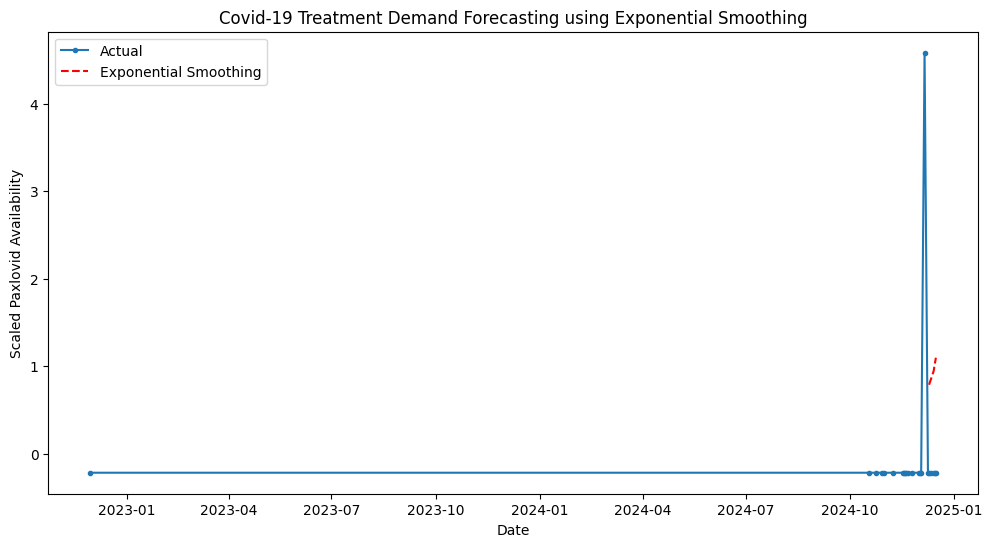

RMSE: 1.16547939850722


In [8]:
# Exponential Smoothing for Time-Series Forecasting

# Aggregate data for time-series analysis
df_time_series = df_cleaned.groupby('Last Report Date').agg({'Has Paxlovid': 'sum'}).reset_index()
df_time_series = df_time_series.sort_values('Last Report Date')

# Convert to time series format
df_time_series.set_index('Last Report Date', inplace=True)

# Standardize data
scaler = StandardScaler()
df_time_series_scaled = scaler.fit_transform(df_time_series)
df_time_series_scaled = pd.DataFrame(df_time_series_scaled, index=df_time_series.index, columns=['Has Paxlovid'])

# Train-Test split (80% train, 20% test)
train_size = int(len(df_time_series_scaled) * 0.8)
train, test = df_time_series_scaled[:train_size], df_time_series_scaled[train_size:]

# Apply exponential smoothing model
exp_model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=True).fit()
exp_forecast = exp_model.forecast(len(test))

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_time_series_scaled.index, df_time_series_scaled, label="Actual", marker='.')
plt.plot(test.index, exp_forecast, label="Exponential Smoothing", linestyle='dashed', color='red')
plt.legend()
plt.title("Covid-19 Treatment Demand Forecasting using Exponential Smoothing")
plt.xlabel("Date")
plt.ylabel("Scaled Paxlovid Availability")
plt.show()

# Calculate RMSE for model evaluation
rmse_exp = np.sqrt(mean_squared_error(test, exp_forecast))
print("RMSE:", rmse_exp)

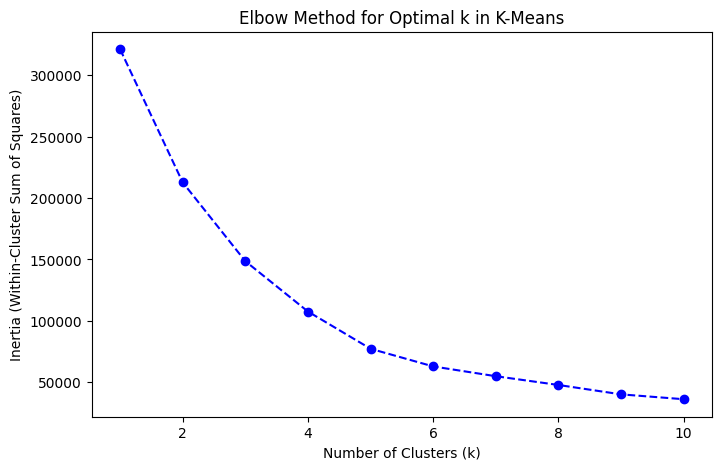

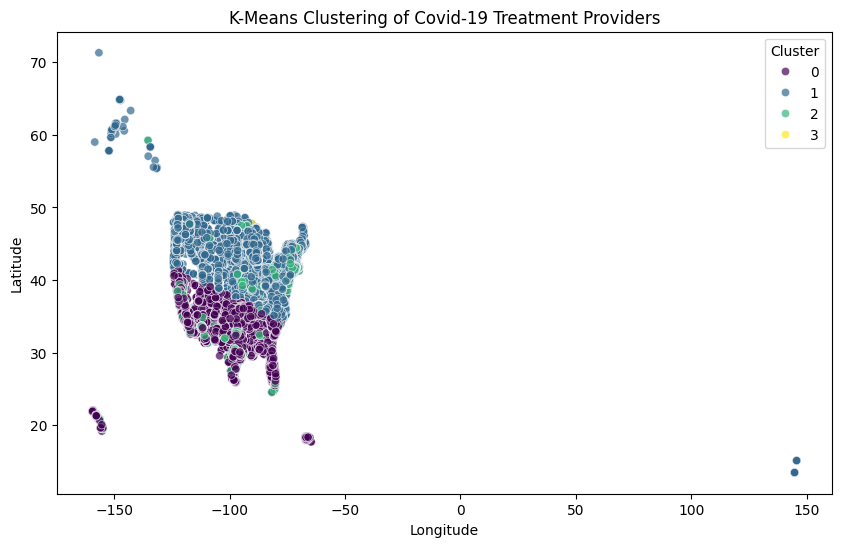

In [9]:
# K-Means Clustering based on medication availability

# Select relevant features for clustering
features = ['Latitude', 'Longitude', 'Has Paxlovid', 'Has Lagevrio', 'Has Veklury']
df_clustering = df_cleaned[features].dropna()

# Standardize the data for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)  # Testing clusters from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='dashed', color='blue')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k in K-Means")
plt.show()

# Apply K-Means Clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clustering['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualize clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clustering['Longitude'], y=df_clustering['Latitude'], hue=df_clustering['Cluster'], palette="viridis", alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering of Covid-19 Treatment Providers")
plt.legend(title="Cluster")
plt.show()

In [10]:
# Multiple Linear Regression for causal analysis

# Select relevant features for regression analysis
features = ['Latitude', 'Longitude', 'Is PAP Site', 'Is Telehealth Site', 'Is T2T Site',
            'Is ICATT Site', 'Has USG Product', 'Has Commercial Product']
target = 'Has Paxlovid'

df_regression = df_cleaned[features + [target]].dropna()

X = df_regression[features]
y = df_regression[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R² Score:", r2)

coefficients = pd.DataFrame({'Feature': features, 'Coefficient': reg_model.coef_})

!pip install ace_tools_open
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Regression Coefficients", dataframe=coefficients)

MSE: 0.001612634171457065
R² Score: 0.9892168468199036
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00
Regression Coefficients


In [11]:
# 5 Fold Cross Validation

from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cross_val_scores = cross_val_score(reg_model, X_scaled, y, cv=kf, scoring='r2')

mean_r2 = np.mean(cross_val_scores)
std_r2 = np.std(cross_val_scores)

{
    "Mean R² Score": mean_r2,
    "Standard Deviation of R²": std_r2,
    "Cross-Validation Scores": cross_val_scores.tolist()
}

{'Mean R² Score': 0.987220648630383,
 'Standard Deviation of R²': 0.0022729999563667934,
 'Cross-Validation Scores': [0.9892168468199035,
  0.9858344171863678,
  0.9878004249443469,
  0.9896984237067508,
  0.9835531304945461]}